# Classification: Art Recognition with TensorFlow and Inception v3/ResNet50

In this example we'll classify an image with the fine-tuned Inception v3 / ResNet50 ArtNet model.


### Set-up

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

import numpy as np
import tensorflow as tf

# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# display plots in this notebook
%matplotlib inline

# set display defaults
#plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

### Helper: Load Graph

In [2]:
def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph

### Helper: Read tensor From Image File

In [3]:
def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(
        file_reader, channels=3, name="png_reader")
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(
        tf.image.decode_gif(file_reader, name="gif_reader"))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
  else:
    image_reader = tf.image.decode_jpeg(
        file_reader, channels=3, name="jpeg_reader")
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0)
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result

### Helper: Load labels

In [4]:
def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label

### Set Parameters & Load Graph

In [5]:
model_file = "./models/output_graph.pb"
label_file = "./models/output_labels.txt"
input_height = 224
input_width = 224
input_mean = 0
input_std = 255
input_layer = "Placeholder"
output_layer = "final_result"

graph = load_graph(model_file)


### Test Data

In [6]:
fileNames = ['./dataPaperTest/1500_TheTransfiguration_Raphael.jpeg',
             './dataPaperTest/1653_Rembrandt_Aristotle_with_a_Bust_of_Homer.jpg',
             './dataPaperTest/1715_Jean-Antoine Watteau_FetesVentiennes.jpeg',
            './dataPaperTest/1812_Jacques-Louis David_Napoleon.jpeg',
            './dataPaperTest/1833_Joseph_Mallord_William_Turner_-_A_Disaster_at_Sea.jpg',
            './dataPaperTest/1869_Edgar Degas_Interior.jpeg',
            './dataPaperTest/1857_Hiroshige_One Hundred Famous Views of Edo _Yoroi Ferry in Koami-cho.jpeg',
            './dataPaperTest/1888_VanGogh_the-rocks.jpg'
            ]

### Run Tests

In [7]:
for file_name in fileNames:
      t = read_tensor_from_image_file(
          file_name,
          input_height=input_height,
          input_width=input_width,
          input_mean=input_mean,
          input_std=input_std)

      input_name = "import/" + input_layer
      output_name = "import/" + output_layer
      input_operation = graph.get_operation_by_name(input_name)
      output_operation = graph.get_operation_by_name(output_name)

      with tf.Session(graph=graph) as sess:
        results = sess.run(output_operation.outputs[0], {
            input_operation.outputs[0]: t
        })
      results = np.squeeze(results)

      top_k = results.argsort()[-3:][::-1]  ## -9 was changed from -5 
      labels = load_labels(label_file)
      print("###############################################")
      print('file Name: ' + file_name) 
    
      for i in top_k:
        percent = results[i] * 100
        percent = '%05.2f' % (percent,)    
        print(labels[i].title() + ": " + str(percent) + "%")

###############################################
file Name: ./dataPaperTest/1500_TheTransfiguration_Raphael.jpeg
Renaissance: 75.39%
Baroque: 10.96%
Rococo: 09.03%
###############################################
file Name: ./dataPaperTest/1653_Rembrandt_Aristotle_with_a_Bust_of_Homer.jpg
Baroque: 99.28%
Realism: 00.63%
Rococo: 00.07%
###############################################
file Name: ./dataPaperTest/1715_Jean-Antoine Watteau_FetesVentiennes.jpeg
Rococo: 81.28%
Baroque: 09.78%
Romantic: 04.76%
###############################################
file Name: ./dataPaperTest/1812_Jacques-Louis David_Napoleon.jpeg
Neoclassical: 98.20%
Modern: 00.80%
Rococo: 00.64%
###############################################
file Name: ./dataPaperTest/1833_Joseph_Mallord_William_Turner_-_A_Disaster_at_Sea.jpg
Romantic: 95.71%
Rococo: 03.22%
Modern: 00.51%
###############################################
file Name: ./dataPaperTest/1869_Edgar Degas_Interior.jpeg
Baroque: 55.23%
Romantic: 15.27%
Realism: 1

## Examine intermediate output

### Final Probability Output

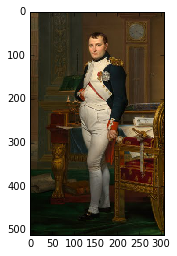

In [8]:
fileNames = ['./dataPaperTest/1812_Jacques-Louis David_Napoleon.jpeg']
image=mpimg.imread(fileNames[0])
plt.imshow(image)

['baroque', 'modern', 'neoclassical', 'realism', 'renaissance', 'rococo', 'romantic', 'ukiyoe']


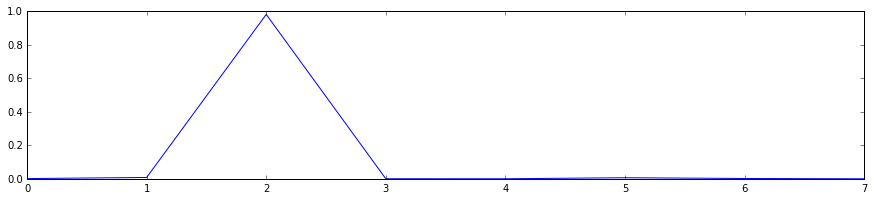

In [9]:
for file_name in fileNames:
      t = read_tensor_from_image_file(
          file_name,
          input_height=input_height,
          input_width=input_width,
          input_mean=input_mean,
          input_std=input_std)

      input_name = "import/" + input_layer
      output_name = "import/" + output_layer
      input_operation = graph.get_operation_by_name(input_name)
      output_operation = graph.get_operation_by_name(output_name)

      with tf.Session(graph=graph) as sess:
        results = sess.run(output_operation.outputs[0], {
            input_operation.outputs[0]: t
        })
      results = np.squeeze(results)

      top_k = results.argsort()[-9:][::-1]  ## -9 was changed from -5 
      labels = load_labels(label_file)
      print(labels)
        
      plt.figure(figsize=(15, 3))
      plt.plot(results)  

In [10]:
results

array([1.3086090e-03, 7.9735583e-03, 9.8195308e-01, 3.8641482e-04,
       1.9082295e-04, 6.3837455e-03, 1.7931749e-03, 1.0645238e-05],
      dtype=float32)